In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from Aggregation import Agregator
import matplotlib.pyplot as plt
from functools import partial

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
f1=lambda x:1-np.sum(np.pi*x,axis=-1)**2/2#+np.sum(np.pi*x,axis=-1)**4/24
f2=lambda x:np.cos(np.pi*np.sum(x,axis=-1))
def get_data(k,scale,seed=0):
    np.random.seed(seed)
    X=scale*(np.random.rand(k,1)-1.0/2)
    Y=np.where(np.sum(X,axis=-1)>0,f1(X),f2(X))
    return X,Y


In [6]:
scale=4
X,Y=get_data(30,scale,seed=56)

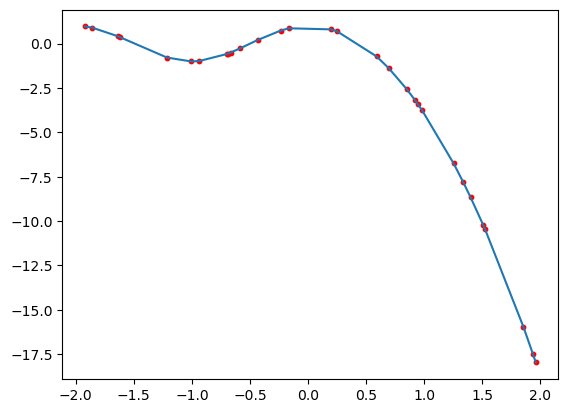

In [7]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted)
plt.scatter(np.sum(X,axis=-1),Y,s=10,c='r')

In [8]:
# Define the models
models = [LinearRegression(), 
          DecisionTreeRegressor(), 
          RandomForestRegressor(), 
          SVR(), 
          KNeighborsRegressor(), 
          GradientBoostingRegressor()
         ]

# Define the model names
model_names = ['Linear Regression', 
               'Decision Tree', 
               'Random Forest', 
               'Support Vector Regression', 
               'KNeighbors Regression', 
               'Gradient Boosting Regression'
              ]
model_number=len(models)

In [9]:
models=list(map(lambda x: x.fit(X,Y),models))
print(list(map(lambda x: x.score(X,Y),models)))

[0.6342118263394486, 1.0, 0.9981497054423479, 0.7147146970116662, 0.9592991054495763, 0.9999995054419785]


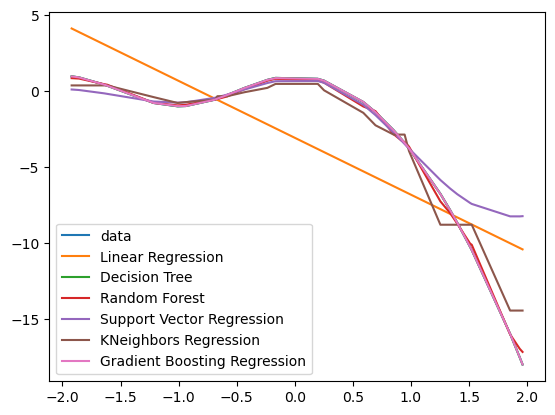

In [10]:
#sort the data by X value
idx=np.argsort(np.sum(X,axis=-1))
X_sorted=X[idx]
Y_sorted=Y[idx]

plt.plot(np.sum(X_sorted,axis=-1),Y_sorted,label='data')
for model,model_name in zip(models,model_names):
    plt.plot(np.sum(X_sorted,axis=-1),model.predict(X_sorted),label=model_name)

plt.legend()

In [11]:
n_additional=10
X_additional,Y_additional=get_data(n_additional,scale,seed=5)
X_test,Y_test=np.concatenate([X_additional,X]),np.concatenate([Y_additional,Y])

In [12]:
def constant_kernel(x,y,mat):
    return np.tile(mat,(x.shape[0],y.shape[0],1,1))

def linear_separable_kernel(x,y,mat):
    K=x@y.T
    return K[:,:,None,None]*mat[None,None,:,:]

from sklearn.metrics.pairwise import rbf_kernel
def gaussian_separable_kernel(x,y,mat,l):
    K=rbf_kernel(x,y,gamma=1/l**2)+0.1
    return K[:,:,None,None]*mat[None,None,:,:]
    
ratio=0.2
constant_mat=(1-ratio)*np.eye(model_number)+ratio*np.ones((model_number,model_number))

model_values=np.stack(list(map(lambda x: x.predict(X_test),models)),axis=0)
constant_mat=(1-ratio)*np.eye(model_number)+ratio*np.corrcoef(model_values)
print(constant_mat)

my_kernel=partial(gaussian_separable_kernel,mat=constant_mat,l=1)

[[1.         0.15792214 0.15914326 0.16510565 0.16370255 0.15792925]
 [0.15792214 1.         0.19980519 0.19044684 0.19676048 0.19999994]
 [0.15914326 0.19980519 1.         0.19165335 0.19796236 0.19980655]
 [0.16510565 0.19044684 0.19165335 1.         0.19402418 0.19044532]
 [0.16370255 0.19676048 0.19796236 0.19402418 1.         0.19676449]
 [0.15792925 0.19999994 0.19980655 0.19044532 0.19676449 1.        ]]


In [13]:
mean_intercept=np.ones(len(models))
mean_intercept=mean_intercept/np.sum(mean_intercept)

In [14]:
aggregate=Agregator(K=my_kernel,models=models,kernel_name='linear',intercept_choice='fit')

In [15]:
aggregate=aggregate.fit(X_test,Y_test,alpha=1e-4)

In [16]:
aggregate.intercept

array([0.08048002, 0.35864671, 0.25050779, 1.76119909, 0.33571396,
       0.3835957 ])

In [17]:
np.linalg.norm(aggregate.coef_,axis=0)

array([0.28838766, 0.13127605, 0.13273481, 0.31929026, 0.10123723,
       0.13463948])

In [18]:
n=1000
X_eval,Y_eval=get_data(n,scale,seed=2)

In [19]:
pred_aggregate,alpha=aggregate.predict(X_eval,return_alpha=True)

<Figure size 640x480 with 0 Axes>

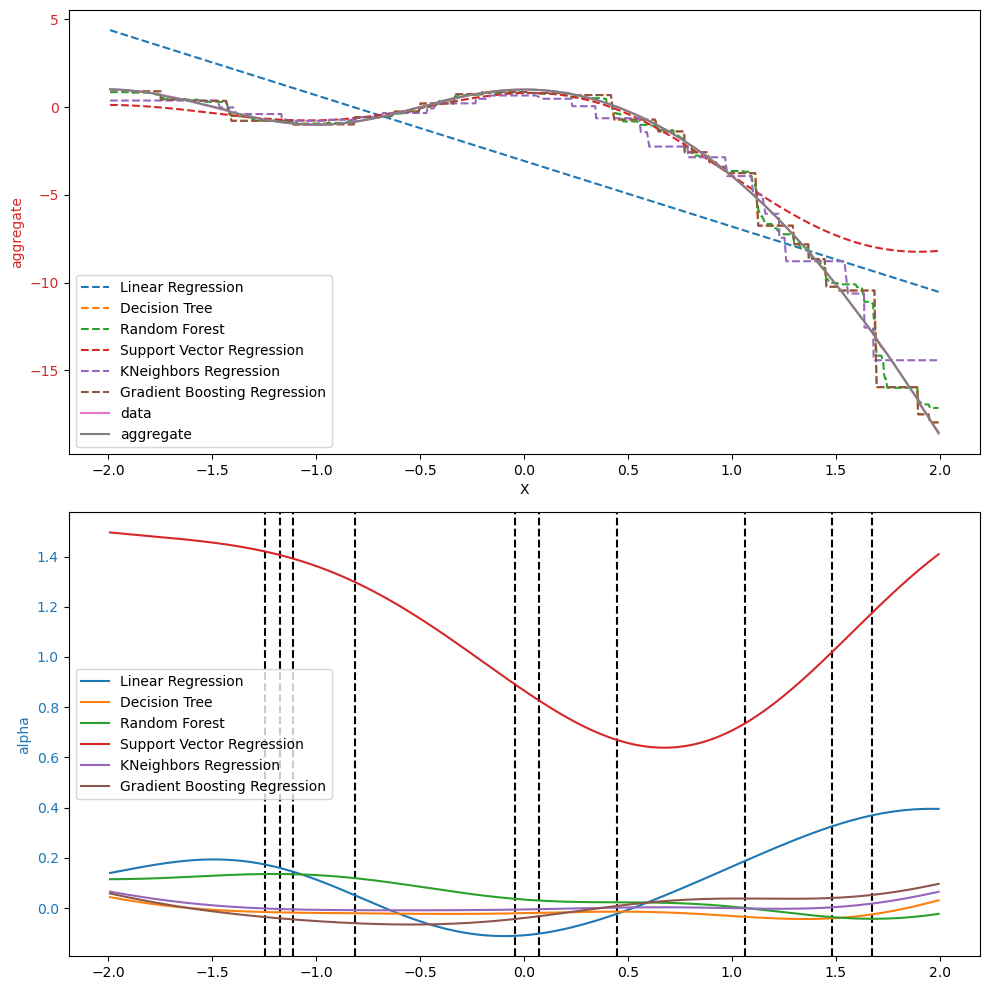

<Figure size 640x480 with 0 Axes>

In [20]:
#sort the data by X value
idx=np.argsort(np.sum(X_eval,axis=-1))
X_eval_sorted=X_eval[idx]
Y_eval_sorted=Y_eval[idx]
pred_aggregate_sorted=pred_aggregate[idx]
#two plot one on top of the other. first one is evolution of the aggregate, second evolution of alpha

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))

color = 'tab:red'
ax1.set_xlabel('X')
ax1.set_ylabel('aggregate', color=color)
ax1.tick_params(axis='y', labelcolor=color)
for model,model_name in zip(models,model_names):
    ax1.plot(np.sum(X_eval_sorted,axis=-1),model.predict(X_eval_sorted),label=model_name,linestyle='--')
ax1.plot(np.sum(X_eval_sorted,axis=-1),Y_eval_sorted,label='data')
ax1.plot(np.sum(X_eval_sorted,axis=-1),pred_aggregate_sorted,label='aggregate')
#ax2 must be a new subplot



color = 'tab:blue'
ax2.set_ylabel('alpha', color=color)  # we already handled the x-label with ax1
for xi in X_additional:
    ax2.axvline(x=np.sum(xi),color='k',linestyle='--')
for i,model in enumerate(model_names):
    ax2.plot(np.sum(X_eval_sorted,axis=-1), alpha[i][idx], label=model)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()
ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.figure()

In [21]:
error_aggregate=np.linalg.norm(Y_eval-pred_aggregate)
error_models={name:np.linalg.norm(Y_eval-model.predict(X_eval)) for name,model in zip(model_names,models)}
error_models['aggregate']=error_aggregate
print('\n'.join(['{}:{}'.format(name,error) for name,error in error_models.items()]))

Linear Regression:103.82411656902167
Decision Tree:17.565885823394634
Random Forest:14.416157092748515
Support Vector Regression:75.15586156936305
KNeighbors Regression:24.316132761804884
Gradient Boosting Regression:17.571549984363003
aggregate:0.4877441439855183
